In [1]:
%load_ext autoreload
%autoreload 1
import time
import pandas as pd
import numpy as np
import random as rn
from tqdm import tqdm
import os

import sys

sys.path.append("../utils/")
%aimport utils

from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from tensorflow import set_random_seed

import seaborn as sns
import matplotlib.pyplot as plt

# reproducibility

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
set_random_seed(seed)
rn.seed(seed)

# maximum number of cores
n_cores = 10

K.set_session(K.tf.Session(config=K.tf.ConfigProto(
    intra_op_parallelism_threads=n_cores, 
    inter_op_parallelism_threads=n_cores
)))

TUMOR = 0
NORMAL = 1

/home/nanni/anaconda3/envs/deeplearning/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
now = time.strftime('%Y%m%d_%H%M')
description = "LUNG_1vsALL_NN_NN"
folder = now + "_" + description

In [ ]:
output_folder = os.path.join("./results/", folder)
output_folder

In [ ]:
writer = pd.ExcelWriter(os.path.join(output_folder, "results.xlsx"), engine='xlsxwriter')

## Data

In [3]:
def get_filtered_features(X):
    #return np.arange(10)
    return X.std(0).argsort()[::-1][:5000]

def preprocess(X):
    scaler = MinMaxScaler()
    return utils.pre_process(X, get_filtered_features, scaler)

In [11]:
colormap = {
    TUMOR: 'red',
    NORMAL: 'blue'
}

def plot_PCA(X, y):
    pca = PCA(n_components=2)
    X_t = pca.fit_transform(X)
    colors = list(map(lambda x: colormap[x], y))
    plt.figure(figsize=(10, 10))
    sns.regplot(x=X_t[:, 0], y=X_t[:, 1], fit_reg=False, scatter_kws={'color': colors, 's': 50})
    return pca

## Procedure

In [65]:
cancer_name = "THCA"
X_c, y_c = utils.get_cancer_data(cancer_name)

# sampler = RandomUnderSampler()
# X_c, y_c = sampler.fit_sample(X_c, y_c)

print("Cancer: {}".format(cancer_name))
print("\t#samples: {}".format(X_c.shape[0]))
print("\t#genes: {}".format(X_c.shape[1]))
print("\t#TUMORS: {}\t#NORMAL: {}".format(y_c[y_c == TUMOR].shape[0], y_c[y_c == NORMAL].shape[0]))

Cancer: THCA
	#samples: 572
	#genes: 20530
	#TUMORS: 513	#NORMAL: 59


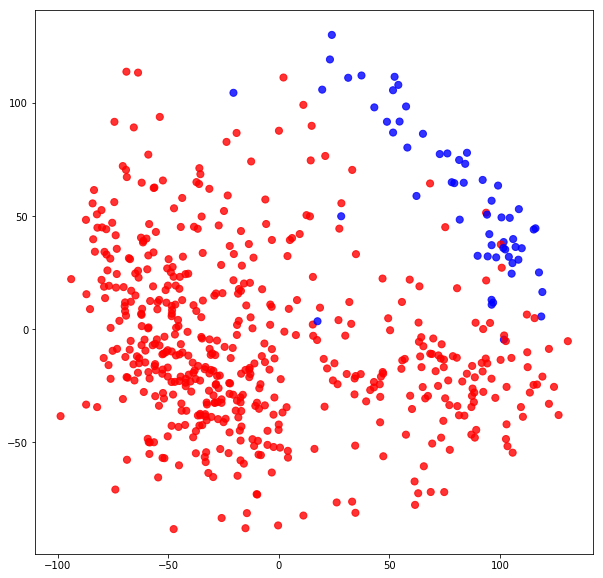

In [66]:
plt.figure(figsize=(10, 10))
pca = plot_PCA(X_c, y_c)
plt.show()

In [58]:
pca.explained_variance_ratio_

array([0.18793998, 0.09037153])

In [32]:
others = list(set(utils.all_tumor_names) - {'BLCA'})
# others = ['OV', 'BRCA']
# print(", ".join(others))

X_others = np.empty((0, X_c.shape[1]), dtype=int)
y_others = np.empty(0, dtype=int)

for o in others:
    print(o)
    X_o, y_o = utils.get_cancer_data(o)
    X_others = np.append(X_others, X_o, axis=0)
    y_others = np.append(y_others, y_o)
    
print("Cancer: {}".format(others))
print("\t#samples: {}".format(X_others.shape[0]))
print("\t#genes: {}".format(X_others.shape[1]))
print("\t#TUMORS: {}\t#NORMAL: {}".format(y_others[y_others == TUMOR].shape[0], y_others[y_others == NORMAL].shape[0]))

KIRC
CESC
UVM
LGG
KIRP
LUAD
ACC
HNSC
ESCA
THCA
PAAD
CHOL
UCS
OV
TGCT
LAML
KICH
READ
BRCA
LUSC
SARC
LIHC
THYM
PCPG
GBM
STAD
MESO
UCEC
COAD
PRAD
DLBC
SKCM
Cancer: ['KIRC', 'CESC', 'UVM', 'LGG', 'KIRP', 'LUAD', 'ACC', 'HNSC', 'ESCA', 'THCA', 'PAAD', 'CHOL', 'UCS', 'OV', 'TGCT', 'LAML', 'KICH', 'READ', 'BRCA', 'LUSC', 'SARC', 'LIHC', 'THYM', 'PCPG', 'GBM', 'STAD', 'MESO', 'UCEC', 'COAD', 'PRAD', 'DLBC', 'SKCM']
	#samples: 10033
	#genes: 20530
	#TUMORS: 9325	#NORMAL: 708


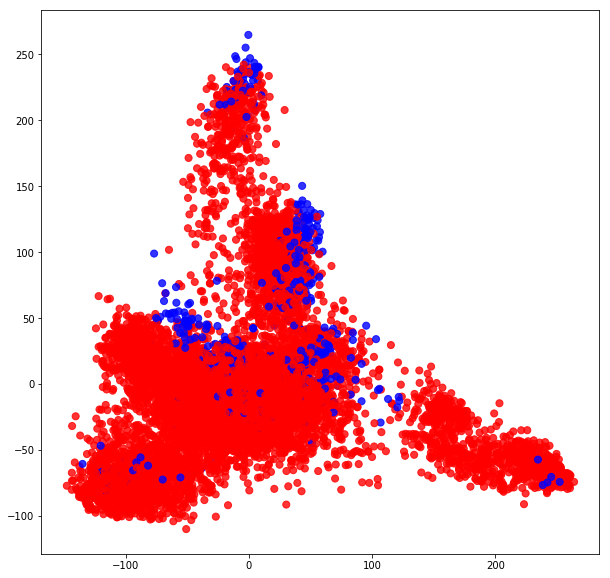

In [33]:
plt.figure(figsize=(10, 10))
plot_PCA(X_others, y_others)
plt.show()

### Tumor alone

In [34]:
def tumor_alone_model(input_size):
    """ A super-simple NN for the single tumor classification
    """
    model = Sequential()
    model.add(Dense(100, input_shape=(input_size,), activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1, activation="sigmoid"))
    return model

In [35]:
cvscores_c, histories_c = utils.cross_validation(X=X_c, y=y_c, 
                                                 preprocess=preprocess, 
                                                 seed=seed, 
                                                 n_randomizations=5,
                                                 create_model=tumor_alone_model, 
                                                 get_measures=utils.get_measures)


f1-score  1.00      precision 1.00      recall    1.00      accuracy  1.00      split     0.00      random_set0.00      
f1-score  0.86      precision 1.00      recall    0.75      accuracy  0.99      split     1.00      random_set0.00      


/home/nanni/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nanni/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


f1-score  0.00      precision 0.00      recall    0.00      accuracy  0.95      split     2.00      random_set0.00      
f1-score  1.00      precision 1.00      recall    1.00      accuracy  1.00      split     3.00      random_set0.00      
f1-score  0.86      precision 0.75      recall    1.00      accuracy  0.99      split     4.00      random_set0.00      
f1-score  1.00      precision 1.00      recall    1.00      accuracy  1.00      split     0.00      random_set1.00      
f1-score  1.00      precision 1.00      recall    1.00      accuracy  1.00      split     1.00      random_set1.00      
f1-score  0.86      precision 1.00      recall    0.75      accuracy  0.99      split     2.00      random_set1.00      
f1-score  1.00      precision 1.00      recall    1.00      accuracy  1.00      split     3.00      random_set1.00      
f1-score  0.80      precision 1.00      recall    0.67      accuracy  0.99      split     4.00      random_set1.00      
f1-score  0.86      precision 1.

In [36]:
cvscores_c.mean().to_frame().T.drop(["split", 'random_set'], axis=1)

,accuracy,f1-score,precision,recall
0,0.991069,0.872635,0.914,0.856667


In [ ]:
utils.report(cvscores_c, writer=writer, sheet_name="{}_alone".format(cancer_name))

### Others alone

In [37]:
def others_alone_model(input_size):
    h1 = 500
    h2 = 200
    h3 = 100
    h4 = 50
    out = 1

    model = Sequential()
    model.add(Dense(h1, input_shape=(input_size, ), activation="relu"))
    model.add(Dense(h2, activation="relu"))
    model.add(Dense(h3, activation="relu"))
    model.add(Dense(h4, activation="relu"))
    model.add(Dense(out, activation="sigmoid"))
    return model

In [ ]:
cvscores_others, histories_others = utils.cross_validation(X=X_others, y=y_others, preprocess=preprocess, 
                                                           seed=seed, create_model=others_alone_model, 
                                                           get_measures=utils.get_measures)
cvscores_others.mean().to_frame().T.drop("split", axis=1)

In [ ]:
utils.report(cvscores_others, writer=writer, sheet_name="{}_others".format(cancer_name))

### Transfer learning

In [38]:
def create_other_network(input_size):
    h1 = 500
    h2 = 200
    h3 = 100
    h4 = 50
    out = 1
    
    model = Sequential()
    model.add(Dense(h1, input_shape=(input_size, ), activation="relu", name='h1'))
    model.add(Dense(h2, activation="relu", name='h2'))
    model.add(Dense(h3, activation="relu", name='h3'))
    model.add(Dense(h4, activation="relu", name='h4'))
    model.add(Dense(out, activation="sigmoid", name='out'))
    
    encoder = Model(inputs=model.input, outputs=model.get_layer("h3").output)
    
    return model, encoder

In [39]:
def create_additional_network(input_size):
    h1 = 50
    h2 = 10
    out = 1
    
    model = Sequential()
    model.add(Dense(h1, input_shape=(input_size, ), activation="relu", name='h1'))
    model.add(Dense(h2, activation="relu", name='h2'))
    model.add(Dense(out, activation="sigmoid", name='out'))
    return model

In [40]:
def tl_data_merging(X, y, train, test, preprocess, validation_split, seed, X_other, y_other):

#     print(X.shape, y.shape)
#     print(X_other.shape, y.shape)
#     print("Splitting of X_c")
    
    # Splitting the single tumor dataset
    X_train, y_train = X[train], y[train]
    X_test, y_test = X[test], y[test]
    
    # get the validation set in a stratified fashion from the training set
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_split,
                                                      random_state=seed, stratify=y_train)
    # Merge the single cancer training set with the other set
    X_train_merged = np.append(X_train, X_other, axis=0)
    y_train_merged = np.append(y_train, y_other)
    
    # preprocess merged training set and get features and scaler
    X_train_merged, scaler, sel_features = preprocess(X_train_merged)
    # transform testing set
    X_test = scaler.fit_transform(X_test[:, sel_features])
    # transform validation set
    X_val = scaler.fit_transform(X_val[:, sel_features])

#     print(X_train_merged.shape, y_train_merged.shape)
#     print(X_val.shape, y_val.shape)
#     print(X_test.shape, y_test.shape)
    
    return X_train_merged, X_val, X_test, y_train_merged, y_val, y_test

In [41]:
def transfer_learning(X, y, train, test, preprocess, validation_split, seed, X_other, y_other):
#     print(X.shape, y.shape)
#     print(X_other.shape, y.shape)
#     print("Splitting of X_c")
    # Splitting the single tumor dataset
    X_train, y_train = X[train], y[train]
    X_test, y_test = X[test], y[test]
    
    # get the validation set in a stratified fashion from the training set
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_split,
                                                      random_state=seed, stratify=y_train)
#     print("Scaling of X_c")
    # preprocess training set and get features and scaler
    X_train, scaler, sel_features = preprocess(X_train)
    # transform testing set
    X_test = scaler.fit_transform(X_test[:, sel_features])
    # transform validation set
    X_val = scaler.fit_transform(X_val[:, sel_features])
    
#     print("Scaling and selection on X_other")
    # for the other set we use a brand new scaler but the same features
    other_scaler = MinMaxScaler()
    X_other = other_scaler.fit_transform(X_other[:, sel_features])
    # splitting other set in training and validation (no test...useless)
    X_other_train, X_other_val, \
    y_other_train, y_other_val = train_test_split(X_other, y_other, test_size=validation_split,
                                                  random_state=seed, stratify=y_other)
    
#     print("Fitting the OTHER model")
    # create and fit the OTHER model
    other_model, encoder = create_other_network(input_size=X_other_train.shape[1])
    other_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
    other_model.fit(X_other_train, y_other_train,
                    epochs=100, batch_size=60,
                    verbose=0, validation_data=(X_other_val, y_other_val),
                    callbacks=[utils.get_early_stopping_condition()])
    
#     print("Encoding X_c")
    # embedding of data
    X_train_code = encoder.predict(X_train)
    X_val_code = encoder.predict(X_val)
    X_test_code = encoder.predict(X_test)
    
#     print(X_train_code.shape)
#     print(X_val_code.shape)
#     print(X_test_code.shape)
    
    return X_train_code, X_val_code, X_test_code, y_train, y_val, y_test

In [42]:
cvscores_tl, histories_tl = utils.cross_validation(X=X_c, y=y_c, preprocess=preprocess, seed=seed, 
                                                   n_randomizations=5,
                                                   create_model=create_additional_network, 
                                                   get_measures=utils.get_measures, 
                                                   data_preparation=transfer_learning, 
                                                   X_other=X_others, y_other=y_others)
cvscores_tl.mean().to_frame().T.drop(["split", 'random_set'], axis=1)

f1-score  1.00      precision 1.00      recall    1.00      accuracy  1.00      split     0.00      random_set0.00      
f1-score  0.89      precision 0.80      recall    1.00      accuracy  0.99      split     1.00      random_set0.00      
f1-score  0.75      precision 0.75      recall    0.75      accuracy  0.98      split     2.00      random_set0.00      
f1-score  1.00      precision 1.00      recall    1.00      accuracy  1.00      split     3.00      random_set0.00      
f1-score  0.75      precision 0.60      recall    1.00      accuracy  0.98      split     4.00      random_set0.00      
f1-score  0.80      precision 0.67      recall    1.00      accuracy  0.98      split     0.00      random_set1.00      
f1-score  1.00      precision 1.00      recall    1.00      accuracy  1.00      split     1.00      random_set1.00      
f1-score  0.86      precision 1.00      recall    0.75      accuracy  0.99      split     2.00      random_set1.00      
f1-score  1.00      precision 1.

,accuracy,f1-score,precision,recall
0,0.989668,0.897123,0.871524,0.95


In [43]:
cvscores_c.mean().to_frame().T.drop(["split", 'random_set'], axis=1)

,accuracy,f1-score,precision,recall
0,0.991069,0.872635,0.914,0.856667


In [ ]:
utils.report(cvscores_tl, writer=writer, sheet_name="{}_TL".format(cancer_name))

In [ ]:
os.makedirs(output_folder, exist_ok=True)

In [ ]:
writer.save()

In [ ]:
cvscores_tl.mean() - cvscores_c.mean()